# Movies Reviews Sentiment Analysis
### Data

In [36]:
%load_ext autoreload
%autoreload 2
# Cargamos el dataset
from util import load_datasets_unlabeled_test
train, dev, test = load_datasets_unlabeled_test(test_size_val=0.2) # en realidad dev_size_val
X_train, y_train = train
X_dev, y_dev = dev
X_test=test  # No tenemos el correspondiente y_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
filename = 'subjectivity_clues_hltemnlp05/subjclueslen1-HLTEMNLP05.tff'
f = open(filename)
lines = f.readlines()
f.close()

In [38]:
words = []
for line in lines:
    sline = line.split()
    dline = dict([token.split('=') for token in sline if '=' in token])
    word = dline['word1']
    pol = dline['priorpolarity']
    if pol not in {'both', 'neutral'}:
        if pol in {'negative', 'weakneg'}:
            pol = 'NEG'
        else:
            pol = 'POS'
        words.append((word, pol))

word_dict = dict(words)

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
tkn = CountVectorizer().build_tokenizer()
def my_tkn(s):
    tokens = tkn(s)
    return [word_dict.get(token, token) for token in tokens]

Train using 
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       419
          1       1.00      1.00      1.00       437

avg / total       1.00      1.00      1.00       856





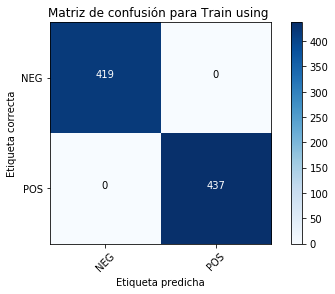

Dev using 
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.83      0.85      0.84       116
          1       0.82      0.80      0.81        98

avg / total       0.83      0.83      0.83       214





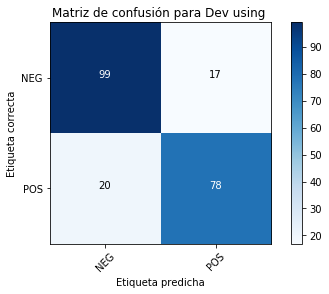

In [41]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from util import print_eval

from util import load_model
model=load_model('pipe_cv_linearsvc_iteparams_first')
params_vec1=model.steps[0][1].get_params()
#params_vec1.update({'stop_words':'english'})
pipeline = Pipeline([
    ('vect', FeatureUnion([
        ('bow', CountVectorizer(**params_vec1)),
        ('pol', CountVectorizer(vocabulary=['POS', 'NEG'], tokenizer=my_tkn)),
    ])),
    ('clf', LinearSVC(random_state=0,C=1)),
])
pipeline.fit(X_train, y_train)
from util import print_plot_classification_report
# Train
print_plot_classification_report(pipeline,X_train,y_train,'Train using ',plotFlag=True,classes_list=['NEG','POS'])
# Dev
print_plot_classification_report(pipeline,X_dev,y_dev,'Dev using ' ,plotFlag=True,classes_list=['NEG','POS'])

## TfidfVectorizer Approach

In [2]:
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from util import eval
from util import iterate_pipeline_params    
import pandas as pd

### LogisticRegression

In [3]:
param_grid = {
    'vect__binary': [True,False],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__min_df': [1, 3, 5],
    'vect__max_df': [0.95, 0.9,0.7],
    'vect__use_idf': [True,False],  
    'vect__sublinear_tf': [True,False], 
    'clf__random_state': [0],
    'clf__C': [1],
}
params_list = list(ParameterGrid(param_grid))

In [4]:
from sklearn.linear_model import LogisticRegression
#
vect = TfidfVectorizer()
clf = LogisticRegression()

pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
#
results=iterate_pipeline_params(pipeline,params_list,X_train,y_train,X_dev, y_dev)

In [5]:
# results to Pandas
results_df = pd.DataFrame(results)
results_df.sort_values(['acc', 'f1'], ascending=False)[:5]

acc  clf__C  clf__random_state        f1  vect__binary  \
12   0.869159       1                  0  0.868746          True   
14   0.869159       1                  0  0.868746          True   
48   0.864486       1                  0  0.863984          True   
50   0.864486       1                  0  0.863984          True   
194  0.864486       1                  0  0.863625         False   

     vect__max_df  vect__min_df vect__ngram_range  vect__sublinear_tf  \
12           0.95             3            (1, 1)                True   
14           0.95             3            (1, 1)               False   
48           0.90             3            (1, 1)                True   
50           0.90             3            (1, 1)               False   
194          0.70             3            (1, 1)               False   

     vect__use_idf  
12            True  
14            True  
48            True  
50            True  
194           True

Train using <class 'sklearn.linear_model.logistic.LogisticRegression'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       419
          1       0.97      0.99      0.98       437

avg / total       0.98      0.98      0.98       856





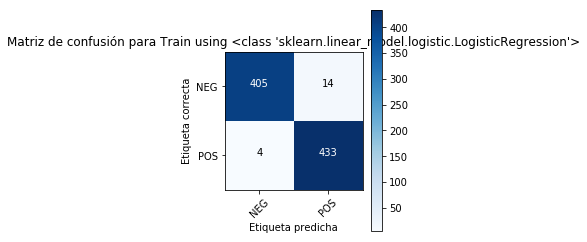

Dev using <class 'sklearn.linear_model.logistic.LogisticRegression'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.90      0.85      0.88       116
          1       0.84      0.89      0.86        98

avg / total       0.87      0.87      0.87       214





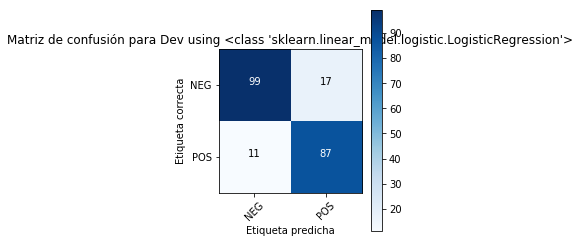

In [7]:
from util import print_plot_classification_report
from util import  load_model,save_model
#
idx=12
vect = TfidfVectorizer()
clf = LogisticRegression()
pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
params_=dict(results_df.iloc[idx].drop(['acc','f1']))
pipeline.set_params(**params_)
pipeline.fit(X_train,y_train)
save_model(pipeline,'pipe_tv_logreg_iteparams_first')
est=str(pipeline.steps[-1][1].__class__)
# Train
print_plot_classification_report(pipeline,X_train,y_train,'Train using ' + est,plotFlag=True,classes_list=['NEG','POS'])
# Dev
print_plot_classification_report(pipeline,X_dev,y_dev,'Dev using ' + est,plotFlag=True,classes_list=['NEG','POS'])

Notemos que LogReg no fittea en forma perfecta el set de entrenamiento (sin embargo da un buen scoring en Dev).

### MultinomialNB

In [8]:
param_grid = {
    'vect__binary': [True,False],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__min_df': [1, 3, 5],
    'vect__max_df': [0.95,0.7,0.5],
    'vect__use_idf': [True,False],  
    'vect__sublinear_tf': [True,False], 
    'clf__alpha': (1, 0.1, 0.01),
}
params_list = list(ParameterGrid(param_grid))

In [9]:
from sklearn.naive_bayes import MultinomialNB

vect = TfidfVectorizer()
clf = MultinomialNB()
pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
results=iterate_pipeline_params(pipeline,params_list,X_train,y_train,X_dev, y_dev)

In [10]:
# results to Pandas
results_df = pd.DataFrame(results)
results_df.sort_values(['acc', 'f1'], ascending=False)[:5]

acc  clf__alpha        f1  vect__binary  vect__max_df  vect__min_df  \
110  0.859813         1.0  0.859211         False          0.95             1   
36   0.855140         1.0  0.854985          True          0.70             1   
38   0.855140         1.0  0.854985          True          0.70             1   
0    0.855140         1.0  0.854756          True          0.95             1   
2    0.855140         1.0  0.854756          True          0.95             1   

    vect__ngram_range  vect__sublinear_tf  vect__use_idf  
110            (1, 1)               False           True  
36             (1, 1)                True           True  
38             (1, 1)               False           True  
0              (1, 1)                True           True  
2              (1, 1)               False           True

Train using <class 'sklearn.naive_bayes.MultinomialNB'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.98      0.99      0.98       419
          1       0.99      0.98      0.98       437

avg / total       0.98      0.98      0.98       856





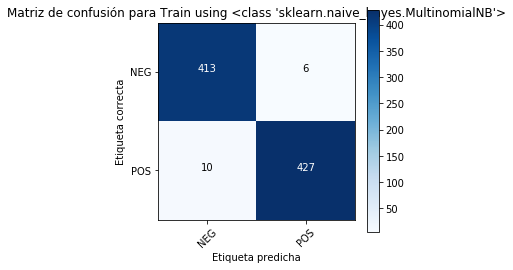

Dev using <class 'sklearn.naive_bayes.MultinomialNB'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.88      0.85      0.87       116
          1       0.83      0.87      0.85        98

avg / total       0.86      0.86      0.86       214





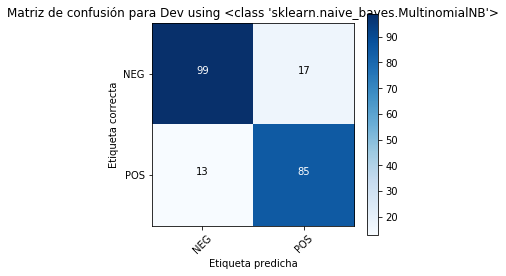

In [11]:
idx=110

vect = TfidfVectorizer()
clf = MultinomialNB()
pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])

params_=dict(results_df.iloc[idx].drop(['acc','f1']))
pipeline.set_params(**params_)
pipeline.fit(X_train,y_train)
save_model(pipeline,'pipe_tv_multinomialNB_iteparams_first')
#
est=str(pipeline.steps[-1][1].__class__)
# Train
print_plot_classification_report(pipeline,X_train,y_train,'Train using ' + est,plotFlag=True,classes_list=['NEG','POS'])
# Dev
print_plot_classification_report(pipeline,X_dev,y_dev,'Dev using ' + est,plotFlag=True,classes_list=['NEG','POS'])

Notemos que MultinomialNB no fittea en forma perfecta el set de entrenamiento (sin embargo da un buen scoring en Dev).

### LinearSVC

In [12]:
param_grid = {
    'vect__binary': [True,False],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__min_df': [1, 3, 5],
    'vect__max_df': [0.95, 0.9,0.7],
    'vect__use_idf': [True,False],  
    'vect__sublinear_tf': [True,False], 
    'clf__random_state': [0],
    'clf__C': [1],
}
params_list = list(ParameterGrid(param_grid))

In [13]:
from sklearn.svm import LinearSVC
#
vect = TfidfVectorizer()
clf = LinearSVC()
pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
#
results=iterate_pipeline_params(pipeline,params_list,X_train,y_train,X_dev, y_dev)

In [14]:
# results to Pandas
results_df = pd.DataFrame(results)
results_df.sort_values(['acc', 'f1'], ascending=False)[:5]

acc  clf__C  clf__random_state        f1  vect__binary  \
110  0.887850       1                  0  0.887051         False   
146  0.883178       1                  0  0.882601         False   
182  0.878505       1                  0  0.877982         False   
122  0.873832       1                  0  0.872829         False   
194  0.873832       1                  0  0.872829         False   

     vect__max_df  vect__min_df vect__ngram_range  vect__sublinear_tf  \
110          0.95             1            (1, 1)               False   
146          0.90             1            (1, 1)               False   
182          0.70             1            (1, 1)               False   
122          0.95             3            (1, 1)               False   
194          0.70             3            (1, 1)               False   

     vect__use_idf  
110           True  
146           True  
182           True  
122           True  
194           True

Observamos que LinearSVC mejora a partir de la busqueda parametrica, sobretodo en la parte de countVectorizer (notemos que C el parametro de regularizacion, no altera el resultado principal).

Train using <class 'sklearn.svm.classes.LinearSVC'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       419
          1       1.00      1.00      1.00       437

avg / total       1.00      1.00      1.00       856





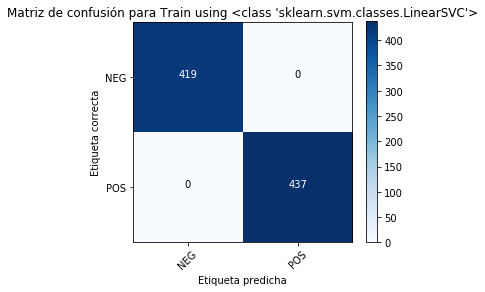

Dev using <class 'sklearn.svm.classes.LinearSVC'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.90      0.90      0.90       116
          1       0.88      0.88      0.88        98

avg / total       0.89      0.89      0.89       214





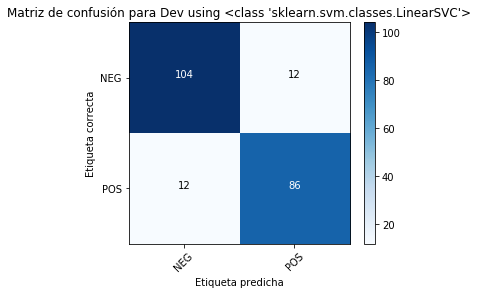

In [15]:
idx=110
vect = TfidfVectorizer()
clf = LinearSVC()
pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
params_=dict(results_df.iloc[idx].drop(['acc','f1']))
pipeline.set_params(**params_)
pipeline.fit(X_train,y_train)
save_model(pipeline,'pipe_tv_linearsvc_iteparams_first')
#
est=str(pipeline.steps[-1][1].__class__)
# Train
print_plot_classification_report(pipeline,X_train,y_train,'Train using ' + est,plotFlag=True,classes_list=['NEG','POS'])
# Dev
print_plot_classification_report(pipeline,X_dev,y_dev,'Dev using ' + est,plotFlag=True,classes_list=['NEG','POS'])